In [2]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 5_Save and Load models

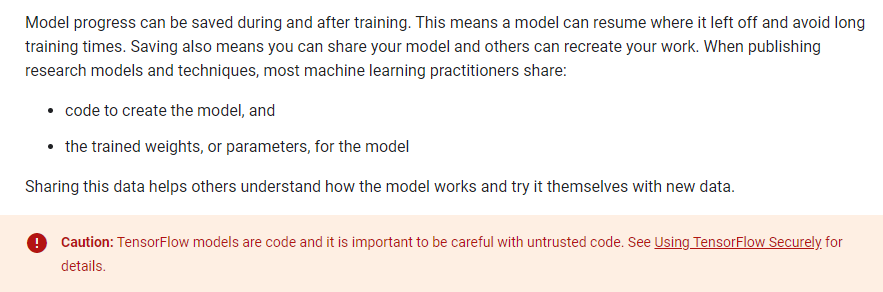

#### Options
There are different ways to save TensorFlow models depending on the API you're using. This guide uses tf.keras—a high-level API to build and train models in TensorFlow. The new, high-level .keras format used in this tutorial is recommended for saving Keras objects, as it provides robust, efficient name-based saving that is often easier to debug than low-level or legacy formats. For more advanced saving or serialization workflows, especially those involving custom objects, please refer to the [Save and load Keras models guide](https://www.tensorflow.org/guide/keras/serialization_and_saving). For other approaches, refer to the [Using the SavedModel format guide](https://www.tensorflow.org/guide/saved_model).

#### Setup
Installs and imports

Install and import TensorFlow and dependencies:

In [3]:
!pip install pyyaml h5py  
#Required to save models in HDF5 format

In [4]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.15.0


#### Get an example dataset
To demonstrate how to save and load weights, you'll use the MNIST dataset. To speed up these runs, use the first 1000 examples:

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

#### Define a model
Start by building a simple sequential model:

In [6]:
# Define a simple sequential model
def create_model():
  model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Save checkpoints during training <a class='anchor' id='1'></a>
You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The tf.keras.callbacks.ModelCheckpoint callback allows you to continually save the model both during and at the end of training.

##### Checkpoint callback usage
Create a tf.keras.callbacks.ModelCheckpoint callback that saves weights only during training:

In [7]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10

26/32 [=======================>......] - ETA: 0s - loss: 1.2580 - sparse_categorical_accuracy: 0.6514 
Epoch 1: saving model to training_1\cp.ckpt
32/32 [==============================] - 1s 9ms/step - loss: 1.1433 - sparse_categorical_accuracy: 0.6800 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.7890
Epoch 2/10
30/32 [===========================>..] - ETA: 0s - loss: 0.4310 - sparse_categorical_accuracy: 0.8729
Epoch 2: saving model to training_1\cp.ckpt
32/32 [==============================] - 0s 4ms/step - loss: 0.4229 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.5348 - val_sparse_categorical_accuracy: 0.8360
Epoch 3/10
28/32 [=========================>....] - ETA: 0s - loss: 0.2966 - sparse_categorical_accuracy: 0.9196
Epoch 3: saving model to training_1\cp.ckpt
32/32 [==============================] - 0s 4ms/step - loss: 0.2926 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.4952 - val_sparse_categorical_accuracy: 0.8470
Epoch 4/10
31/32 [========

This creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch:

In [8]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

Now rebuild a fresh, untrained model and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy):

In [9]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 2.4152 - sparse_categorical_accuracy: 0.1100 - 126ms/epoch - 4ms/step
Untrained model, accuracy: 11.00%


Then load the weights from the checkpoint and re-evaluate:

In [10]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4072 - sparse_categorical_accuracy: 0.8680 - 42ms/epoch - 1ms/step
Restored model, accuracy: 86.80%


#### Checkpoint callback options
The callback provides several options to provide unique names for checkpoints and adjust the checkpointing frequency.

Train a new model, and save uniquely named checkpoints once every five epochs:

In [11]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to training_2\cp-0005.ckpt

Epoch 10: saving model to training_2\cp-0010.ckpt

Epoch 15: saving model to training_2\cp-0015.ckpt

Epoch 20: saving model to training_2\cp-0020.ckpt

Epoch 25: saving model to training_2\cp-0025.ckpt

Epoch 30: saving model to training_2\cp-0030.ckpt

Epoch 35: saving model to training_2\cp-0035.ckpt

Epoch 40: saving model to training_2\cp-0040.ckpt

Epoch 45: saving model to training_2\cp-0045.ckpt

Epoch 50: saving model to training_2\cp-0050.ckpt


Now, review the resulting checkpoints and choose the latest one:

In [12]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0000.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0020.ckpt.data-00000-of-00001',
 'cp-0020.ckpt.index',
 'cp-0025.ckpt.data-00000-of-00001',
 'cp-0025.ckpt.index',
 'cp-0030.ckpt.data-00000-of-00001',
 'cp-0030.ckpt.index',
 'cp-0035.ckpt.data-00000-of-00001',
 'cp-0035.ckpt.index',
 'cp-0040.ckpt.data-00000-of-00001',
 'cp-0040.ckpt.index',
 'cp-0045.ckpt.data-00000-of-00001',
 'cp-0045.ckpt.index',
 'cp-0050.ckpt.data-00000-of-00001',
 'cp-0050.ckpt.index']

In [13]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2\\cp-0050.ckpt'

To test, reset the model, and load the latest checkpoint:

In [14]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4838 - sparse_categorical_accuracy: 0.8800 - 121ms/epoch - 4ms/step
Restored model, accuracy: 88.00%


#### What are these files?
The above code stores the weights to a collection of checkpoint-formatted files that contain only the trained weights in a binary format. Checkpoints contain:

- One or more shards that contain your model's weights.
- An index file that indicates which weights are stored in which shard.

If you are training a model on a single machine, you'll have one shard with the suffix: .data-00000-of-00001

#### Manually save weights <a class='anchor' id='2'></a>
To save weights manually, use tf.keras.Model.save_weights. By default, tf.keras—and the Model.save_weights method in particular—uses the TensorFlow Checkpoint format with a .ckpt extension. To save in the HDF5 format with a .h5 extension, refer to the Save and load models guide.

In [15]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4838 - sparse_categorical_accuracy: 0.8800 - 118ms/epoch - 4ms/step
Restored model, accuracy: 88.00%


#### Save the entire model <a class='anchor' id='3'></a>
Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single model.keras zip archive.

An entire model can be saved in three different file formats (the new .keras format and two legacy formats: SavedModel, and HDF5). Saving a model as path/to/model.keras automatically saves in the latest format.

You can switch to the SavedModel format by:

- Passing save_format='tf' to save()
- Passing a filename without an extension

You can switch to the H5 format by:

- Passing save_format='h5' to save()
- Passing a filename that ends in .h5

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

*Custom objects (for example, subclassed models or layers) require special attention when saving and loading. Refer to the Saving custom objects section below.

#### New high-level .keras format <a class='anchor' id='4'></a>
The new Keras v3 saving format, marked by the .keras extension, is a more simple, efficient format that implements name-based saving, ensuring what you load is exactly what you saved, from Python's perspective. This makes debugging much easier, and it is the recommended format for Keras.

The section below illustrates how to save and restore the model in the .keras format.

In [20]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 1.1672 - sparse_categorical_accuracy: 0.6690
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4405 - sparse_categorical_accuracy: 0.8800
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9280
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9490
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9640


Reload a fresh Keras model from the .keras zip archive:

In [21]:
new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Try running evaluate and predict with the loaded model:

In [23]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

32/32 - 0s - loss: 0.4376 - sparse_categorical_accuracy: 0.8530 - 44ms/epoch - 1ms/step
Restored model, accuracy: 85.30%
32/32 [==============================] - 0s 735us/step
(1000, 10)


#### SavedModel format <a class='anchor' id='5'></a>
The SavedModel format is another way to serialize models. Models saved in this format can be restored using tf.keras.models.load_model and are compatible with TensorFlow Serving. [The SavedModel guide](https://www.tensorflow.org/guide/saved_model) goes into detail about how to serve/inspect the SavedModel. The section below illustrates the steps to save and restore the model.

In [24]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 1.1593 - sparse_categorical_accuracy: 0.6800
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4087 - sparse_categorical_accuracy: 0.8890
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2892 - sparse_categorical_accuracy: 0.9240
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9530
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9660
INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


The SavedModel format is a directory containing a protobuf binary and a TensorFlow checkpoint. Inspect the saved model directory:

In [31]:
# my_model directory
#ls saved_model #use dir instead of ls in windows
!dir saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
#ls saved_model/my_model
!dir saved_model/my_model

 Volume in drive D is WD SN850X 2TB
 Volume Serial Number is C0A1-C967

 Directory of d:\TensorFlowLearning\ML Basics with Keras\saved_model

03/21/2024  10:09 AM    <DIR>          .
03/21/2024  10:09 AM    <DIR>          ..
03/21/2024  10:09 AM    <DIR>          my_model
               0 File(s)              0 bytes
               3 Dir(s)  1,393,233,969,152 bytes free


Invalid switch - "my_model".


Reload a fresh Keras model from the saved model:

In [32]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               401920    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The restored model is compiled with the same arguments as the original model. Try running evaluate and predict with the loaded model:

In [33]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

32/32 - 0s - loss: 0.4296 - sparse_categorical_accuracy: 0.8620 - 121ms/epoch - 4ms/step
Restored model, accuracy: 86.20%
32/32 [==============================] - 0s 845us/step
(1000, 10)


#### HDF5 format <a class='anchor' id='6'></a>
Keras provides a basic legacy high-level save format using the HDF5 standard.

In [34]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 1.1231 - sparse_categorical_accuracy: 0.6850
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8930
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.9340
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1941 - sparse_categorical_accuracy: 0.9480
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9730


d:\TensorFlowLearning\ML Basics with Keras\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Now, recreate the model from that file:

In [35]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               401920    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

32/32 - 0s - loss: 0.4197 - sparse_categorical_accuracy: 0.8690 - 121ms/epoch - 4ms/step
Restored model, accuracy: 86.90%


Keras saves models by inspecting their architectures. This technique saves everything:

- The weight values
- The model's architecture
- The model's training configuration (what you pass to the .compile() method)
- The optimizer and its state, if any (this enables you to restart training where you left off)

Keras is not able to save the v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints. For v1.x optimizers, you need to re-compile the model after loading—losing the state of the optimizer.

#### Saving custom objects
If you are using the SavedModel format, you can skip this section. The key difference between high-level .keras/HDF5 formats and the low-level SavedModel format is that the .keras/HDF5 formats uses object configs to save the model architecture, while SavedModel saves the execution graph. Thus, SavedModels are able to save custom objects like subclassed models and custom layers without requiring the original code. However, debugging low-level SavedModels can be more difficult as a result, and we recommend using the high-level .keras format instead due to its name-based, Keras-native nature.

To save custom objects to .keras and HDF5, you must do the following:

1. Define a get_config method in your object, and optionally a from_config classmethod.
- get_config(self) returns a JSON-serializable dictionary of parameters needed to recreate the object.
- from_config(cls, config) uses the returned config from get_config to create a new object. By default, this function will use the config as initialization kwargs (return cls(**config)).

2. Pass the custom objects to the model in one of three ways:
- Register the custom object with the @tf.keras.utils.register_keras_serializable decorator. (recommended)
- Directly pass the object to the custom_objects argument when loading the model. The argument must be a dictionary mapping the string class name to the Python class. E.g., tf.keras.models.load_model(path, custom_objects={'CustomLayer': CustomLayer})
- Use a tf.keras.utils.custom_object_scope with the object included in the custom_objects dictionary argument, and place a tf.keras.models.load_model
(path) call within the scope.

Refer to the [Writing layers and models from scratch tutorial](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing) for examples of custom objects and get_config.